# IMPORT

In [163]:

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from palmerpenguins import load_penguins
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Tải dataset Heart Disease từ UCI

In [164]:
penguins = load_penguins()

# Hàm Dataset Preprocessing

In [165]:
#Làm sạch dữ liệu
X = penguins.dropna().drop(columns=["species"])
y = penguins.dropna()["species"]

In [166]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

def preprocess_data(X, y, test_size=0.2):
    # Phát hiện các cột phân loại và số
    categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # Tạo ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(strategy='mean'), numerical_columns),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)
        ]
    )
    
    # Xử lý dữ liệu
    X_processed = preprocessor.fit_transform(X)
    
    # Tạo danh sách tên cột
    feature_names = numerical_columns.copy()
    if categorical_columns:
        onehot_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
        feature_names.extend(onehot_features)
    
    # Tạo DataFrame với tên cột đúng
    X_df = pd.DataFrame(X_processed, columns=feature_names)
    
    # Chia dữ liệu thành train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_df, y, test_size=test_size, random_state=42, shuffle=True
    )
    
    return X_train, X_test, y_train, y_test, X_df

# Chọn bài toán và thiết lập dataset cho bài toán

In [167]:
test_size_options = [0.1, 0.2, 0.2, 0.4, 0.6]
test_size = 0
is_max_depth_experiment = False

print("#1 train/test = 90/10")
print("#2 train/test = 80/20")
print("#3 train/test = 80/20 (with max_depth experiment)")
print("#4 train/test = 60/40")
print("#5 train/test = 40/60")

pick = int(input("Pick a proportion (1-5): #"))
test_size = test_size_options[pick - 1]

max_depth_text, is_max_depth_experiment = ("(with max_depth experiment)", True) if pick == 3 else ("", False)

print(f"-> train/test = {100 - int(test_size*100)}/{int(test_size*100)} {max_depth_text}")

X_train, X_test, y_train, y_test, X_df = preprocess_data(X, y, test_size)

#1 train/test = 90/10
#2 train/test = 80/20
#3 train/test = 80/20 (with max_depth experiment)
#4 train/test = 60/40
#5 train/test = 40/60
-> train/test = 90/10 


# Hàm huấn luyện Decision Tree

In [168]:
def train_decision_tree(max_depth):
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)
    return clf

# Hàm dự đoán trên tập test

In [169]:
def y_predicts(clf, X_test):
    return clf.predict(X_test)

# Các hàm báo cáo đánh giá mô hình

## Hàm xuất classification report và confusion matrix

In [170]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Classification report -----------------------------------------------------------------------------------------
def print_classification_report(y_test, y_pred, target_names):
    print("Classification Report:")
    report = classification_report(y_test, y_pred, target_names=target_names)
    print(report)

# Confusion matrix ----------------------------------------------------------------------------------------------
def draw_confusion_matrix(y_test, y_pred, target_names, class_labels):
    cm = confusion_matrix(y_test, y_pred, labels=class_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=target_names)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap="Blues", values_format='d')
    
    # 👉 Xoay nhãn trục y
    plt.setp(ax.get_yticklabels(), rotation=90)
    
    # 👉 Tăng khoảng cách giữa nhãn "True label" và trục y
    ax.set_ylabel("True label", labelpad=15)
    
    plt.title(f"Confusion Matrix (Depth={clf.get_depth()}, {100 - int(test_size*100)}/{int(test_size*100)} Split)")
    plt.grid(False)
    plt.show()

## Hàm vẽ cây

In [171]:
from sklearn import tree
from graphviz import Source
from IPython.display import display

def draw_decision_tree_v2(clf, feature_names=None, class_names=None):
    dot_data = tree.export_graphviz(
        clf,
        out_file=None,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        special_characters=True
    )
    graph = Source(dot_data)
    display(graph)

## Các hàm đánh giá thí nghiệm Max Depth

In [172]:
from IPython.display import display, Markdown
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

def accuracy_statistics(max_depth_options, accuracy_scores):
    col_names = ["None" if x is None else x for x in max_depth_options]
    
    # Tạo DataFrame
    df = pd.DataFrame([accuracy_scores], columns=col_names).round(4)
    
    # Đặt tên cho dòng và cột
    df.index = ["Accuracy"]
    df.columns.name = "max_depth"
    
    # Hiển thị
    display(df)

def accuracy_chart(max_depth_options, accuracy_scores):
    # Map max_depth_options: None => -1 (chỉ để vẽ), giữ lại label
    plot_x = [-1 if v is None else v for v in max_depth_options]
    
    plt.figure(figsize=(8, 6))
    plt.plot(plot_x, accuracy_scores, marker='o', linestyle='-', color='b')
    
    # Thêm tiêu đề và nhãn
    plt.title('Accuracy vs Max Depth', fontsize=14)
    plt.xlabel('Max Depth', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    
    # Gán nhãn trục x theo max_depth_options gốc
    plt.xticks(plot_x, labels=[str(v) if v is not None else "None" for v in max_depth_options])
    
    plt.grid(True)
    plt.show()

# Output

In [173]:
# Các label và tên class tương ứng
class_labels = penguins["species"].unique()
target_names = ["Adelie", "Chinstrap", "Gentoo"]


Classification Report:
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        15
   Chinstrap       1.00      1.00      1.00        10
      Gentoo       1.00      1.00      1.00         9

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34



---

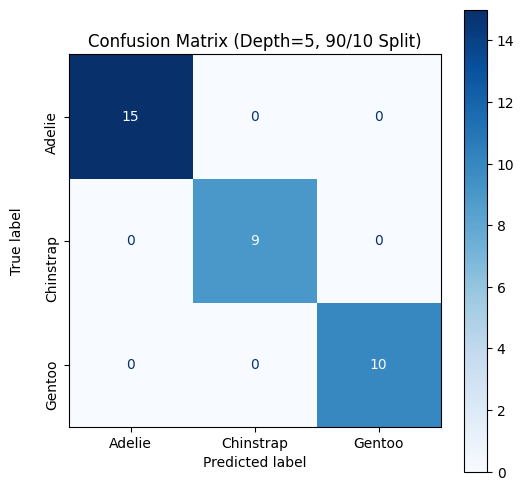

---

## 🌲 Decision Tree:

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [174]:
if is_max_depth_experiment:
    max_depth_options = [None, 2, 3, 4, 5, 6, 7]
    clf_containers = []
    accuracy_scores = []
    
    for max_depth in max_depth_options:
        clf = train_decision_tree(max_depth)
        clf_containers.append(clf)
        accuracy_scores.append(accuracy_score(y_test, y_predicts(clf, X_test)))
    accuracy_statistics(max_depth_options, accuracy_scores)
    accuracy_chart(max_depth_options, accuracy_scores)   
else:
    max_depth = None
    
    clf = train_decision_tree(max_depth)
    y_pred = y_predicts(clf, X_test)
    
    print_classification_report(y_test, y_pred, target_names)
    display(Markdown("---"))
    
    draw_confusion_matrix(y_test, y_pred, target_names, class_labels)   
    display(Markdown("---"))
    display(Markdown(f"## 🌲 Decision Tree:"))
    draw_decision_tree_v2(clf, feature_names=X_df.columns, class_names=target_names)
